In [6]:
from google.colab import files

uploaded = files.upload()  # Загрузить .pth и .onnx файлы


In [1]:
!unzip data.zip

Archive:  data.zip
   creating: data/
   creating: data/test/
   creating: data/test/Гароу/
  inflating: data/test/Гароу/013102fda42dfdc2c2a359e7c9531b5a.jpg  
  inflating: data/test/Гароу/0395dd3d75bc6d6e11dbe0191957c64f.jpg  
  inflating: data/test/Гароу/057b32c2f97746486a21823c8cea832e.jpg  
  inflating: data/test/Гароу/085c4c4181b3ac6e7c3f0d0057e0d3e8.jpg  
  inflating: data/test/Гароу/08e3fc36a7770a93afd9f12b0399747c.jpg  
  inflating: data/test/Гароу/10a877784c5dd578a886ec0cf910d840.jpg  
  inflating: data/test/Гароу/11e39109852587aa65bd87367ae7bd57.jpg  
  inflating: data/test/Гароу/1372b64bda974b264fa9b91070cc73c7.jpg  
  inflating: data/test/Гароу/15073794ebf23959c5164fcf55a933af.jpg  
  inflating: data/test/Гароу/164986cbdc7c8dc79dec9d542b95b856.jpg  
  inflating: data/test/Гароу/18137053b2ac9330749d752404a8fb0e.jpg  
  inflating: data/test/Гароу/24b92d48f3e61c2b8f8995efd8ade833.jpg  
  inflating: data/test/Гароу/26a5d5dbbcccce80d2a44eb3b978d79e.jpg  
  inflating: data/test/Г

       size  batch_size  torch_time_ms  onnx_time_ms  tensorrt_time_ms  \
0   224x224           1       6.681681      7.204503          3.691807   
1   224x224           4       7.877573      5.478099          7.907838   
2   224x224           8      10.753796      9.779483         13.452366   
3   224x224          16      14.038995     15.497059         20.881549   
4   256x256           1       2.807125      2.225846          3.539681   
5   256x256           4       8.828416      5.945370          8.403599   
6   256x256           8      10.792851     11.099324         12.877852   
7   256x256          16      17.014593     20.888641         20.521238   
8   384x384           1       3.296912      3.659323          5.331621   
9   384x384           4      14.155194     12.366489         13.225928   
10  384x384           8      22.267014     24.421439         24.176762   
11  384x384          16      36.976427     40.854573         42.969793   
12  512x512           1       4.919469

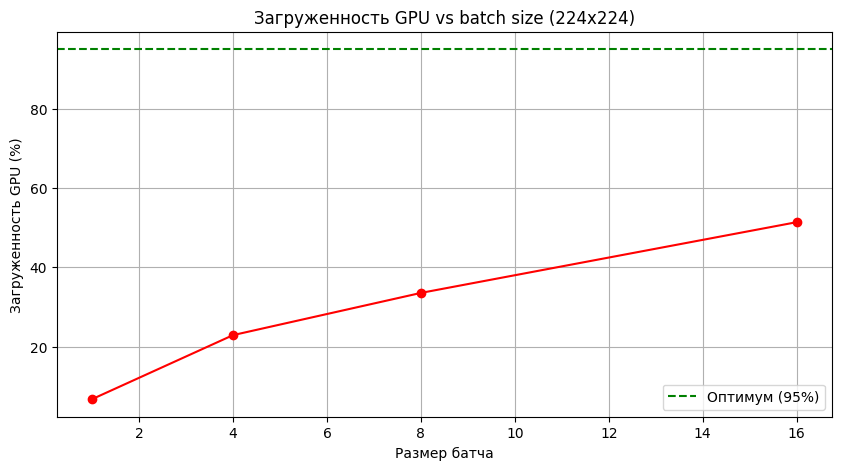

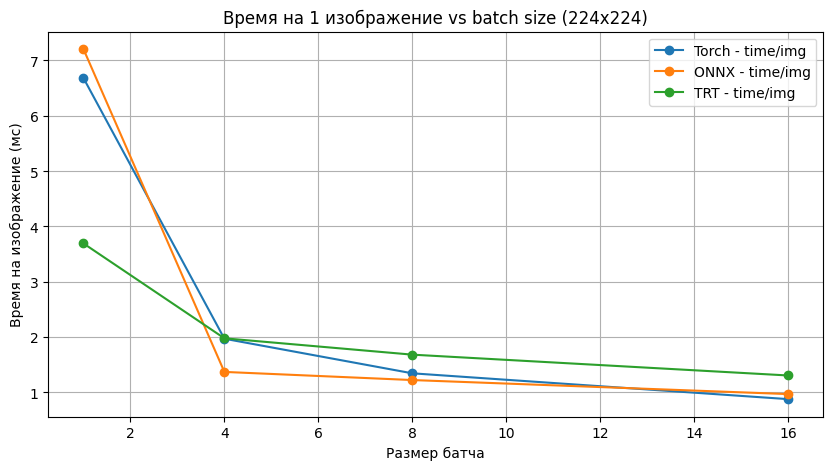

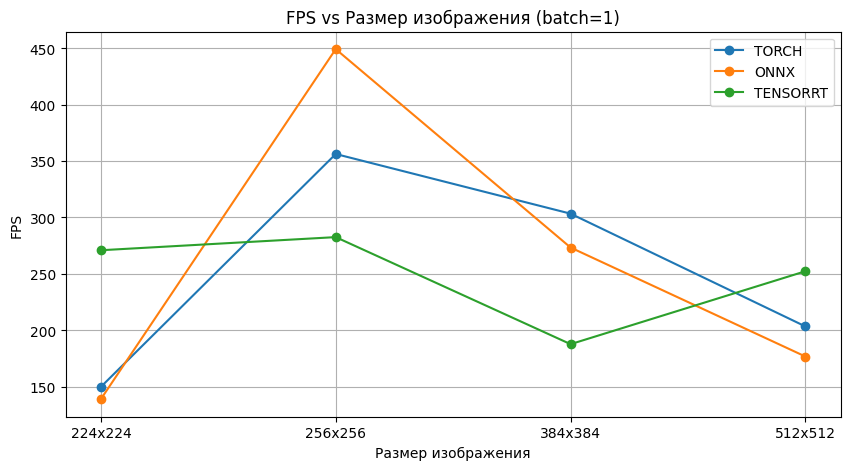

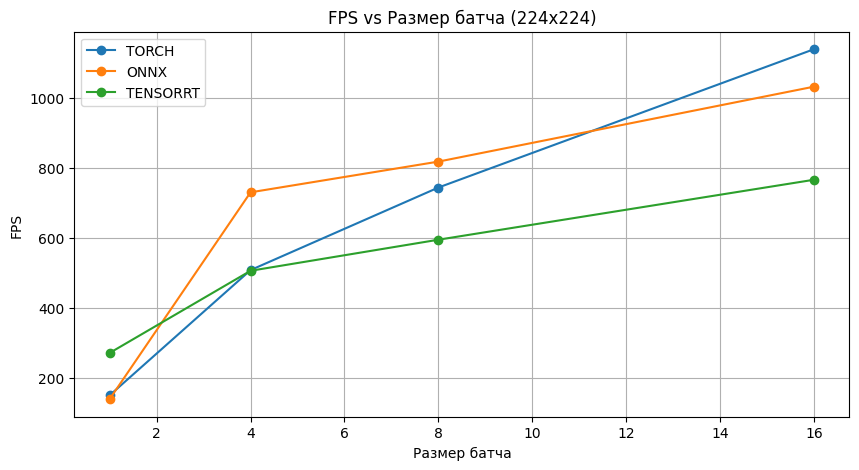

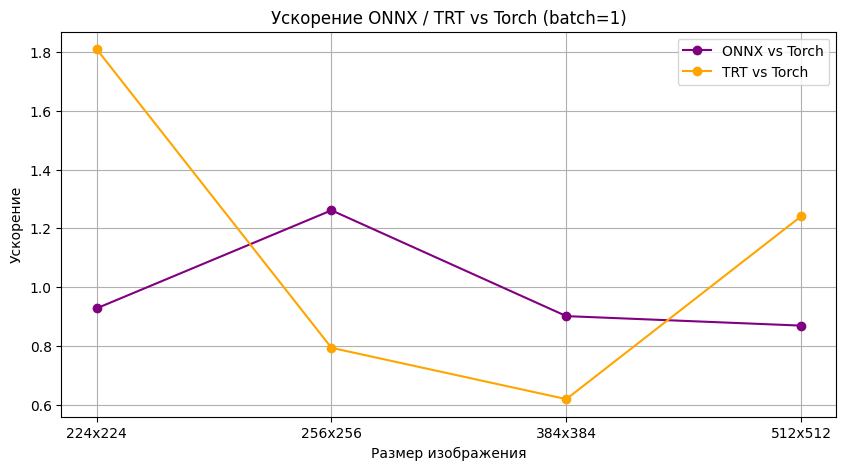

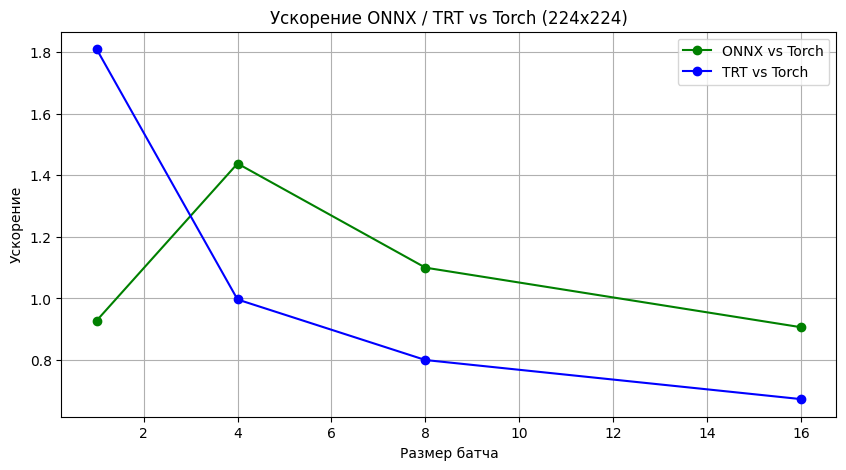

In [3]:
# Colab: Сравнение инференса PyTorch, ONNX и Torch-TensorRT на GPU

# Установка зависимостей
# !pip install torch torchvision torchaudio torch-tensorrt onnx onnxruntime
# !pip install --upgrade git+https://github.com/pytorch/TensorRT.git
# !pip install onnxruntime-gpu
# !pip install ptflops


import torch
import time
import onnxruntime as ort
import torch_tensorrt
from torchvision import transforms
from torchvision.models import resnet18
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ptflops import get_model_complexity_info

def get_flops(model, input_res=(3, 224, 224)):
    with torch.cuda.device(0):
        macs, _ = get_model_complexity_info(model, input_res, as_strings=False,
                                            print_per_layer_stat=False, verbose=False)
    flops = macs * 2
    return flops

theoretical_tflops = 8.1

device = 'cuda' if torch.cuda.is_available() else 'cpu'

pth_path = "best_resnet18_224.pth"
onnx_path = "best_resnet18_224.onnx"
image_path = "data/test/Гароу/013102fda42dfdc2c2a359e7c9531b5a.jpg"

sizes = [(224,224), (256,256), (384,384), (512,512)]
batch_sizes = [1, 4, 8, 16]

def load_model(pth_path, device):
    checkpoint = torch.load(pth_path, map_location=device)
    sd = checkpoint.get('resnet', checkpoint)
    new_sd = {k[len('resnet.'):] if k.startswith('resnet.') else k: v for k, v in sd.items()}
    model = resnet18(weights=None)
    model.fc = torch.nn.Linear(model.fc.in_features, 1000)
    model.load_state_dict(new_sd)
    model.eval().to(device)
    return model

def preprocess(image_path, size, batch_size):
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img = Image.open(image_path).convert('RGB')
    tensor = transform(img).unsqueeze(0)
    batch = tensor.repeat(batch_size,1,1,1)
    return batch.to(device)

def infer(model, batch):
    times = []
    with torch.no_grad():
        for _ in range(20):
            start = time.time()
            _ = model(batch)
            torch.cuda.synchronize()
            end = time.time()
            times.append((end - start)*1000)
    times = np.array(times)
    times = np.sort(times)[2:-2]
    return times.mean()

def infer_onnx(onnx_path, batch):
    batch_cpu = batch.cpu().numpy()
    sess = ort.InferenceSession(onnx_path, providers=["CUDAExecutionProvider", "CPUExecutionProvider"])
    input_name = sess.get_inputs()[0].name
    times = []
    for _ in range(20):
        start = time.time()
        _ = sess.run(None, {input_name: batch_cpu})
        end = time.time()
        times.append((end - start)*1000)
    times = np.array(times)
    times = np.sort(times)[2:-2]
    return times.mean()

def compile_trt(model, example_input):
    model.eval()
    model = model.to("cuda")
    trt_model = torch_tensorrt.compile(
        model,
        inputs=[torch_tensorrt.Input(example_input.shape, dtype=torch.float32)],
        enabled_precisions={torch.float32},  # или {torch.float16} если хочешь FP16
        truncate_long_and_double=True
    )
    return trt_model

results = []

for size in sizes:
    pth_path = f"best_resnet18_{size[0]}.pth"
    onnx_path = f"best_resnet18_{size[0]}.onnx"

    model = load_model(pth_path, device)
    flops_per_image = get_flops(model, input_res=(3, size[0], size[1]))

    for batch_size in batch_sizes:
        batch = preprocess(image_path, size, batch_size)

        torch_time = infer(model, batch)
        onnx_time = infer_onnx(onnx_path, batch)
        trt_model = compile_trt(model, batch)
        trt_time = infer(trt_model, batch)

        time_sec = torch_time / 1000
        total_flops = flops_per_image * batch_size
        actual_tflops = total_flops / time_sec / 1e12
        utilization = actual_tflops / theoretical_tflops * 100

        results.append({
            'size': f"{size[0]}x{size[1]}",
            'batch_size': batch_size,
            'torch_time_ms': torch_time,
            'onnx_time_ms': onnx_time,
            'tensorrt_time_ms': trt_time,
            'torch_fps': batch_size / (torch_time / 1000),
            'onnx_fps': batch_size / (onnx_time / 1000),
            'tensorrt_fps': batch_size / (trt_time / 1000),
            'onnx_speedup_vs_torch': torch_time / onnx_time,
            'tensorrt_speedup_vs_torch': torch_time / trt_time,
            'image_time_ms': torch_time / batch_size,
            'utilization_percent': utilization,
        })




df = pd.DataFrame(results)
print(df)
#Построим график загруженности GPU
plt.figure(figsize=(10,5))
data = df[df['size'] == '224x224']
plt.plot(data['batch_size'], data['utilization_percent'], marker='o', color='red')
plt.axhline(y=95, color='green', linestyle='--', label='Оптимум (95%)')
plt.title('Загруженность GPU vs batch size (224x224)')
plt.xlabel('Размер батча')
plt.ylabel('Загруженность GPU (%)')
plt.legend()
plt.grid(True)
plt.show()


# Время на 1 изображение (PyTorch) при 224x224
plt.figure(figsize=(10,5))
data = df[df['size'] == '224x224']
plt.plot(data['batch_size'], data['torch_time_ms'] / data['batch_size'], marker='o', label='Torch - time/img')
plt.plot(data['batch_size'], data['onnx_time_ms'] / data['batch_size'], marker='o', label='ONNX - time/img')
plt.plot(data['batch_size'], data['tensorrt_time_ms'] / data['batch_size'], marker='o', label='TRT - time/img')  # 🆕
plt.title('Время на 1 изображение vs batch size (224x224)')
plt.xlabel('Размер батча')
plt.ylabel('Время на изображение (мс)')
plt.legend()
plt.grid(True)
plt.show()


# Построим графики FPS vs размер изображения для batch_size=1
plt.figure(figsize=(10,5))
for method in ['torch_fps', 'onnx_fps', 'tensorrt_fps']:  # 🆕
    data = df[df['batch_size']==1]
    plt.plot(data['size'], data[method], marker='o', label=method.replace('_fps', '').upper())
plt.title('FPS vs Размер изображения (batch=1)')
plt.xlabel('Размер изображения')
plt.ylabel('FPS')
plt.legend()
plt.grid(True)
plt.show()


# Построим графики FPS vs batch_size для размер 224x224
plt.figure(figsize=(10,5))
for method in ['torch_fps', 'onnx_fps', 'tensorrt_fps']:  # 🆕
    data = df[df['size']=='224x224']
    plt.plot(data['batch_size'], data[method], marker='o', label=method.replace('_fps', '').upper())
plt.title('FPS vs Размер батча (224x224)')
plt.xlabel('Размер батча')
plt.ylabel('FPS')
plt.legend()
plt.grid(True)
plt.show()

# График 3.1: Ускорение ONNX vs Размер изображения (при batch=1)
plt.figure(figsize=(10,5))
data = df[df['batch_size'] == 1]
plt.plot(data['size'], data['onnx_speedup_vs_torch'], marker='o', color='purple', label='ONNX vs Torch')
plt.plot(data['size'], data['tensorrt_speedup_vs_torch'], marker='o', color='orange', label='TRT vs Torch')  # 🆕
plt.title('Ускорение ONNX / TRT vs Torch (batch=1)')
plt.xlabel('Размер изображения')
plt.ylabel('Ускорение')
plt.grid(True)
plt.legend()
plt.show()

# График 3.2: Ускорение ONNX vs Размер батча (при 224x224)
plt.figure(figsize=(10,5))
data = df[df['size'] == '224x224']
plt.plot(data['batch_size'], data['onnx_speedup_vs_torch'], marker='o', color='green', label='ONNX vs Torch')
plt.plot(data['batch_size'], data['tensorrt_speedup_vs_torch'], marker='o', color='blue', label='TRT vs Torch')  # 🆕
plt.title('Ускорение ONNX / TRT vs Torch (224x224)')
plt.xlabel('Размер батча')
plt.ylabel('Ускорение')
plt.grid(True)
plt.legend()
plt.show()
